# (Traditional) Autoencoder

In [1]:
import torch  
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from typing import List

In [2]:
# HYPERPARAMETER
batch_size =  64
epochs = 3
lr = 0.1

### Data

In [3]:
# DATA LOADER
transforms = transforms.ToTensor()

train_data = datasets.MNIST('data/mnist', train=True, download=True, transform=transforms)
test_data  = datasets.MNIST('data/mnist', train=False, download=True, transform=transforms)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
# DATA: look at pixels value range (important for activation function in decoder)
imgs, labels = next(iter(train_dataloader))

print( torch.min(imgs)  , torch.max(imgs) )

tensor(0.) tensor(1.)


### Autoencoder classes

In [5]:
class Autoencoder_Linear(nn.Module):
    '''AE using fully connected layers'''
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 48),
            nn.ReLU(),
            nn.Linear(48, 2),
        ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 48),
            nn.ReLU(),
            nn.Linear(48, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        return

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [6]:
class Autoencoder_Conv(nn.Module):
    def __init__(self):
        super().__init__()

        pass 

    def forward(self, x):
        pass 

### Train & Test functions

In [7]:
def train(epochs: int, model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion) -> List[float]:
    model.train()
    
    n_batches = len(dataloader)
    losses: List[float] = []

    for i_epoch in range(epochs):
        loss_epoch = 0
        for i_batch, (X,_) in enumerate(dataloader):
            # adjust shahpe of tensor, so that it fits into first layer
            X = X.reshape(-1, 28*28) 

            # pred (encode & decode)
            recon = model(X)

            # loss (how much difference between each pixel)
            loss = criterion(recon, X)
            loss_epoch += loss

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print
            if i_batch % 250 == 0:
                print(f'Epoch\t{i_epoch+1}/{epochs}\t\tBatch\t{i_batch}/{n_batches}\t({(100. * i_batch / n_batches):.1f}%)\t\tLoss\t{loss:.4f}')
        
        loss_epoch = loss_epoch / n_batches
        losses.append(loss_epoch)
    
    return losses


In [15]:
def test(model:nn.Module, dataloader:DataLoader, criterion) -> None:
    model.eval()

    n_batches = len(dataloader)
    loss = 0

    with torch.no_grad():
        for i_batch, (X,_) in enumerate(dataloader):
            X = X.reshape(-1,  28*28)

            # pred 
            recon = model(X)

            # loss
            loss += criterion(recon, X)

        loss = loss / n_batches

    return loss

### Visualization

In [9]:
import matplotlib.pyplot as plt 

def plot_losses(losses: List[float]) -> None:
    '''plots loss per epoch'''
    epochs = range(1, len(losses)+1)

    xticks = range(min(epochs), max(epochs)+1) # transforms into integer

    plt.plot(epochs, losses)
    plt.title('Loss per epoch'), plt.ylabel('Loss'),  plt.xlabel('Epoch')
    plt.xticks(xticks)
    plt.legend()
    plt.show()

    return

### Training

In [10]:
model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [11]:
losses = train(epochs, model, train_dataloader, optimizer, criterion)

Epoch	1/3		Batch	0/938	(0.0%)		Loss	0.2322
Epoch	1/3		Batch	250/938	(26.7%)		Loss	0.2247
Epoch	1/3		Batch	500/938	(53.3%)		Loss	0.2130
Epoch	1/3		Batch	750/938	(80.0%)		Loss	0.1787
Epoch	2/3		Batch	0/938	(0.0%)		Loss	0.0956
Epoch	2/3		Batch	250/938	(26.7%)		Loss	0.0752
Epoch	2/3		Batch	500/938	(53.3%)		Loss	0.0716
Epoch	2/3		Batch	750/938	(80.0%)		Loss	0.0670
Epoch	3/3		Batch	0/938	(0.0%)		Loss	0.0672
Epoch	3/3		Batch	250/938	(26.7%)		Loss	0.0649
Epoch	3/3		Batch	500/938	(53.3%)		Loss	0.0660
Epoch	3/3		Batch	750/938	(80.0%)		Loss	0.0704


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


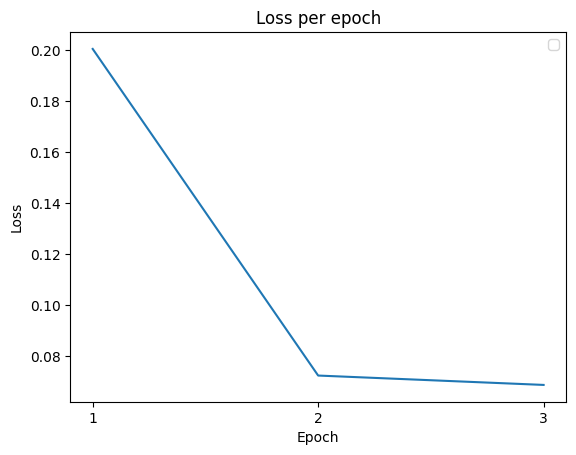

In [12]:
plot_losses(torch.Tensor(losses))

In [17]:
test(model, test_dataloader,  criterion).item()

0.06839210540056229